# Recommender systems: Factorization Machines 

Source (FM): https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf

Source (Triplet Loss): https://en.wikipedia.org/wiki/Triplet_loss 

Source (Keras): https://keras.io/api/layers/core_layers/

Source (AUC-ROC-CURVE): https://en.wikipedia.org/wiki/Receiver_operating_characteristic

The goal of this project is to:
 - offer an implementation of the FM model using keras layers
 - compare the performance of the FM model with a baseline (and triplet loss)
 - show how the FM model with an augmented dataset solves the cold start problem
 - provide a movie representation based on preferences

## Preliminary work

#### 1. Import libraries

In [208]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd

In [209]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf

In [210]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense, Concatenate
from keras.layers import Lambda, Dot, Reshape, Add
from keras.regularizers import l2
from keras.layers.merge import dot, concatenate
from keras.utils import plot_model

In [211]:
from IPython.display import display_html
# Source: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

#### 2. Import data

In [223]:
path_ml = "/Users/stanislasbucaille/Desktop/data_bases/data_movieLens/ml-100k/"

users = pd.read_csv(path_ml + 'u.user', delimiter='|', header=None, names=['id','age','sexe','occupation','zip code'])
items = pd.read_csv(path_ml + 'u.item', delimiter='|', encoding='latin-1', header=None, names=['movieId','title','date','N','url',*[f'g{i}' for i in range(19)]])
occupations = pd.read_csv(path_ml + 'u.occupation', delimiter='\n', header=None).values
genres_ = pd.read_csv(path_ml + 'u.genre', delimiter='\n', header=None).values

train = pd.read_csv(path_ml + 'ua.base', delimiter='\t', header=None, names=['user_id','movie_id','rating','timestemp'])
test = pd.read_csv(path_ml + 'ua.test', delimiter='\t', header=None, names=['user_id','movie_id','rating','timestemp'])

In [224]:
train = train.sort_values(by=['user_id','timestemp'])
test = test.sort_values(by=['user_id','timestemp'])

In [225]:
train.shape, test.shape

((90570, 4), (9430, 4))

In [226]:
display(pd.DataFrame(train).head(1), pd.DataFrame(users).head(1), pd.DataFrame(items).head(1))

,user_id,movie_id,rating,timestemp
161,1,168,5,874965478


,id,age,sexe,occupation,zip code
0,1,24,M,technician,85711


,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## Data preprocessing

#### 1. Clean data

Users

In [227]:
users.head(1)

,id,age,sexe,occupation,zip code
0,1,24,M,technician,85711


In [228]:
# drop id, zip_code 
#users = users.drop(['zip code', 'id'], axis=1)
users = users.drop(['zip code'], axis=1)

# map sexe
users['sexe'] = (users['sexe'] == 'M')*1

# map occupation
dic_occ = {}
id_occ = 0
for occ in occupations.ravel():
    dic_occ[occ] = id_occ
    id_occ += 1

df_occ = []
for occ in users['occupation']:
    df_occ.append([dic_occ[occ]])

users['occupation'] = pd.DataFrame(df_occ)

# map age
df_age = []
for age in users['age']:
    if age <= 25:
        df_age.append([0])
    elif 25 < age <= 50:
        df_age.append([1])
    elif 50 < age:
        df_age.append([2])
        
users['age'] = pd.DataFrame(df_age)

In [229]:
users.head(1)

,id,age,sexe,occupation
0,1,0,1,19


Items

In [230]:
items.head(1)

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [231]:
# drop id, url, N, date
#items = items.drop(['movieId','url', 'N', 'date'], axis = 1)
items = items.drop(['url', 'N', 'date'], axis = 1)

# genres
titles = items['title']
genres = items.drop(['title'], axis = 1)

df_genres = []
for i in range(len(genres)):
    #item_genres = np.array(genres.iloc[i])
    #df_genres.append((item_genres,))
    
    # Only keep the first genre 
    item_genres = np.where(genres.iloc[i])[0][0]
    df_genres.append([item_genres])

items = pd.DataFrame(titles)
items['genres'] = pd.DataFrame(df_genres, columns=['cat_genres'])

In [233]:
items_ = pd.DataFrame(titles)
items_['genres'] = pd.DataFrame(df_genres, columns=['cat_genres'])

In [236]:
items = items.drop(['title'], axis = 1)
items.head(1)

,movieId,g0,g1,g2,g3,g4,g5,g6,g7,g8,...,g10,g11,g12,g13,g14,g15,g16,g17,g18,genres
0,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2. Convert train & test to sparse matrices

Train

In [237]:
# Binary classification 
train['rating'] = (train['rating'] >= 4)*1
train = train.drop(['timestemp'], axis=1)

# Sparse train
row = np.array(train['user_id'].values) - 1
col = np.array(train['movie_id'].values) - 1
data = train['rating'].values

train_rating = sparse.csr_matrix((data, (row, col)))

Test

In [238]:
# Binary classification 
test['rating'] = (test['rating'] >= 4)*1
test = test.drop(['timestemp'], axis=1)

# Sparse test
row = np.array(test['user_id'].values) - 1
col = np.array(test['movie_id'].values) - 1
data = test['rating'].values

test_rating = sparse.csr_matrix((data, (row, col)))

In [239]:
# Feedbacks 
train_feedback = train_rating
test_feedback = test_rating

#### 3. Other useful information

In [240]:
# Some statistics 
display(stats.describe(train_rating.data)) # train
display(stats.describe(test_rating.data))  # test

DescribeResult(nobs=90570, minmax=(0, 1), mean=0.5510213094843768, variance=0.24739955756244064, skewness=-0.20515614730202367, kurtosis=-1.9579109552241896)

DescribeResult(nobs=9430, minmax=(0, 1), mean=0.5799575821845175, variance=0.2436326209601096, skewness=-0.3239999615325726, kurtosis=-1.8950240249268913)

In [241]:
n_users = users.shape[0]
n_items = items.shape[0]
n_occupations = occupations.shape[0]
n_genres = genres.shape[1]

n_users, n_items, n_occupations, n_genres

(943, 1682, 21, 20)

## Baseline model

In [242]:
dic_Baseline = {}
for movie, df_movies  in train.groupby(['movie_id']):
    baseline_pred = sum(df_movies['rating'])/len(df_movies['rating'])
    dic_Baseline[movie] = baseline_pred

In [243]:
scores = []
error = 0
for u, df_u  in test.groupby(['user_id']):
    try:
        # Prediction by movie
        y_predicted = []
        for movie in list(df_u['movie_id']):
            y_predicted.append(dic_Baseline[movie])
            
        # Expectation
        y_expected = df_u['rating']

        # ROC AUC (there might be a problem if only one class is present)
        # Note: in this case it is complicated to use stratified Kfold
        scores.append(roc_auc_score(y_expected, y_predicted))
    except:
        error += 1
error = error/n_users

In [244]:
print('Score: '+ str(np.mean(scores)))
print('Error: '+ str(round(error*1000)/10) + '%')

Score: 0.6980287192482314
Error: 4.3%


## Content - based

In [245]:
new_users = users.copy()
df_occ = pd.get_dummies(new_users['occupation'])
new_users = pd.concat([new_users,df_occ], axis=1).drop(['occupation'], axis=1)

new_users.head(3)

,id,age,sexe,0,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,20
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [246]:
len(train), len(test), len(users), len(items)

(90570, 9430, 943, 1682)

In [263]:
#new_users_ = new_users.div(new_users.sum(axis=1), axis=0)
new_users_test = new_users
#new_users_test[list(new_users_test)[1:]] = new_users_test[list(new_users_test)[1:]].div(10, axis=0)
new_users_test.head(3)

,id,age,sexe,0,1,2,3,4,5,6,...,11,12,13,14,15,16,17,18,19,20
0,1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
1,2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1


In [284]:
n = 3
a = [1,3,2,7,1]

top_2_idx = np.argsort(a)[-n:]
top_2_values = [a[i] for i in top_2_idx]


In [285]:
top_2_idx, top_2_values

(array([2, 1, 3]), [2, 3, 7])

In [ ]:
# cluster from cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

dic_users = {}
for user1 in new_users_test.iterrows():
    dic_cosinsim = {}
    id1 = user1[1]['id']
    vect1 = np.array(user1[1][list(new_users_test)[1:]])
    for user2 in new_users_test.iterrows():
        id2 = user2[1]['id']
        vect2 = np.array(user2[1][list(new_users_test)[1:]])
        dic_cosinsim[id2] = cosine_similarity([vect1], [vect2])[0][0]
        
    dic_users[id1] = dic_cosinsim

In [146]:
from sklearn.cluster import KMeans

def create_clusters(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    dic_clusters = {}
    for id in range(len(data)):
        id_cluster = kmeans.labels_[id]
        if id_cluster not in dic_clusters:
            dic_clusters[id_cluster] = [id]
        else:
            dic_clusters[id_cluster].append(id)
    
    return kmeans, dic_clusters

In [152]:
n_clusters = 3
kmeans, dic_clusters = create_clusters(new_users, n_clusters=n_clusters)

In [154]:
dic_ContentBase = {}

for movie, df_movies  in train.groupby(['movie_id']):
    for cluster_id in range(n_clusters):
        list_users = dic_clusters[cluster_id]
        df_cluster = df_movies[df_movies['user_id'].isin(list_users)]
        if len(df_cluster['rating']) > 0:
            pred_cluster = sum(df_cluster['rating'])/len(df_cluster['rating'])
            dic_ContentBase[(cluster_id, movie)] = pred_cluster

In [ ]:
scores = []
error = 0
for u, df_u  in test.groupby(['user_id']):
    # user's cluster
    cluster_id = kmeans.labels_[u-1]
    try:
        # Prediction
        y_predicted = []
        for movie in list(df_u['movie_id']):
            y_predicted.append(dic_ContentBase[(cluster_id, movie)])

        # Expectation
        y_expected = df_u['rating']

        # ROC AUC (there might be a problem if only one class is present)
        # Note: in this case it is complicated to use stratified Kfold
        scores.append(roc_auc_score(y_expected, y_predicted))
    except:
        error += 1
error = error/n_users

In [ ]:
print('Score: '+ str(np.mean(scores)))
print('Error: '+ str(round(error*1000)/10) + '%')

###  Content by sim

In [289]:
similarities = np.dot(np.array(new_users_test[list(new_users_test)[1:]]), 
                      np.array(new_users_test[list(new_users_test)[1:]].T))

In [318]:
len(similarities)

943

In [327]:
n = 943

def get_cluster(u, n):
    u_sim = similarities[u]
    return np.argsort(u_sim)[-n:]

In [328]:
def get_rating(u, i, n):
    list_users = get_cluster(u, n)
    
    df_movies = train[train['movie_id']==i]
    df_cluster = df_movies[df_movies['user_id'].isin(list_users)]
    
    pred = None
    if len(df_cluster['rating']) > 0:
        pred = sum(df_cluster['rating'])/len(df_cluster['rating'])
    return pred

In [330]:
def get_scores(n):
    scores = []
    error = 0
    for u, df_u  in test.groupby(['user_id']):
        try:
            # Prediction
            y_predicted = []
            for i in list(df_u['movie_id']):
                y_predicted.append(get_rating(u, i, n))

            # Expectation
            y_expected = df_u['rating']

            # ROC AUC (there might be a problem if only one class is present)
            # Note: in this case it is complicated to use stratified Kfold
            scores.append(roc_auc_score(y_expected, y_predicted))
        except:
            error += 1
    error = error/n_users
    return np.mean(scores), round(error*1000)/10

In [331]:
print('Score: '+ str(np.mean(scores)))
print('Error: '+ str(round(error*1000)/10) + '%')

Score: 0.698242098726283
Error: 4.5%


In [332]:
N = [950, 900, 850, 800, 750, 700, 650, 600, 300, 150, 50]

scores = []
errors = []
for n in N:
    score, error = get_scores(n)
    scores.append(score)
    errors.append(error)

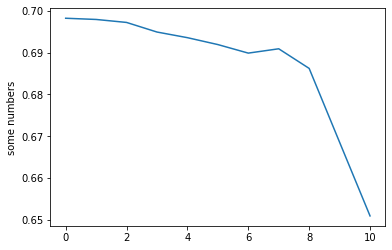

In [333]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.ylabel('some numbers')
plt.show()

In [215]:
def get_score(n_clusters):
    kmeans, dic_clusters = create_clusters(new_users, n_clusters=n_clusters)
    dic_rating = get_dic_rating(dic_clusters)
    
    print(dic_clusters)
    print(dic_rating)
    
    scores = []
    errors = []
    for u, df_u  in test.groupby(['user_id']):
        err = 0
        # cluster
        c = kmeans.labels_[u-1]

        # Prediction / Expectation
        predicted = []
        expected = []
        for i, r in np.array(df_u[['movie_id', 'rating']]):
            try:
                r_pred = dic_rating[(c,i)]
                if pred != None:
                    predicted.append(r_pred)
                    expected.append(r)
                else:
                    err += 1
            except:
                print("error 1")
                err += 1
        try:
            scores.append(roc_auc_score(expected, predicted))
            print(score)
        except:
            print("error 2")
            # there is a single class :  
            #scores.append(1)
            #print(1)
            continue
        errors.append(err/len(df_u))
    
    score = np.mean(scores)
    error = round(np.mean(errors)*1000)/10
    return score, error

In [ ]:
nb_clusters = [1, 3, 7, 10, 25, 50]
scores = []
for k in nb_clusters:
    k_score = get_score(k)[0]
    scores.append(k_score)
    #print(k, k_score)
    break

## Triplet loss model

In [127]:
# Loss
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred + 0 * y_true)

def difference_loss(inputs, margin=.5):
    positive_pair_sim, negative_pair_sim = inputs
    return tf.maximum(negative_pair_sim - positive_pair_sim + margin, 0)

In [128]:
# Network

def build_triplet_models(n_users, n_items, latent_dim=64):
    """Build a triplet model and its companion, the match model
    
    The triplet model is used to train the weights of the 
    match model. The triplet model takes 1 user, 1 positive item, 
    1 negative item and is trained with the triplet loss.
    
    The match model takes 1 user and 1 item as input and returns
    the similarity score.
    """
    # inputs
    user_input = Input((1,), name='user_input')
    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')

    # embeddings
    user_layer = Embedding(n_users, latent_dim, 
                           name='user_embedding')
    item_layer = Embedding(n_items, latent_dim, 
                           name="item_embedding")

    user_embedding = Flatten()(user_layer(user_input))
    positive_item_embedding = Flatten()(item_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_layer(negative_item_input))

    # similarity as cosine similarity between embeddings
    positive_similarity = Dot(name="positive_similarity",
                              axes=1, normalize=True)(
        [user_embedding, positive_item_embedding])
    negative_similarity = Dot(name="negative_similarity",
                              axes=1, normalize=True)(
        [user_embedding, negative_item_embedding])

    # triplet loss net, only used for training
    triplet_loss = Lambda(difference_loss,
                          name='triplet_loss',
                          output_shape=(1,))([positive_similarity, negative_similarity])

    triplet_model = Model(name='Triplet loss net',inputs=[user_input,
                                  positive_item_input,
                                  negative_item_input],
                          outputs=triplet_loss)
    
    # match model, used to rank items
    match_model = Model(name='Match net', inputs=[user_input, positive_item_input],
                        outputs=positive_similarity)
    
    return triplet_model, match_model

In [129]:
triplet_model, match_model = build_triplet_models(n_users, n_items)

In [130]:
print(triplet_model.summary())

Model: "Triplet loss net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
positive_item_input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        60352       user_input[0][0]                 
___________________________________________________________________________________

#### Metric

In [131]:
def model_scores(match_model):
    """Compute the ROC AUC score of each user"""
    scores = []
    error = 0
    for i in range(n_users):
        # items not in the training set
        items_to_rank = np.setdiff1d(np.arange(n_items), train_feedback[i].indices)
        
        # items in the test set = 1, others = 0
        expected = np.in1d(items_to_rank, test_feedback[i].indices)
        
        # model prediction
        repeated_user = np.repeat(i, repeats=len(items_to_rank))
        predicted = match_model.predict([repeated_user, items_to_rank], batch_size=4096).ravel()
        
        # ROC AUC
        try:
            scores.append(roc_auc_score(expected, predicted))
        except:
            error += 1
            
    error = error/n_users
    return error, scores

In [132]:
error, scores = model_scores(match_model)
print('Score: '+ str(np.mean(scores)))
print('Error: '+ str(round(error*1000)/10) + '%')

Score: 0.5001609651730774
Error: 0.0%


As expected, the current model (not yet trained) gives a ROC AUC score similar to that of a random score function.

#### Sample triplets

In [133]:
def sample_triplets():
    """Sample negatives at random among items not in the train set"""
    
    users = []
    pos_items = []
    neg_items = []
    
    for i in range(n_users):
        items = train_feedback[i].indices
        
        users += list(i * np.ones_like(items))
        pos_items += list(items)
        
        unseen_items = np.where(1-train_feedback[i].toarray())[1]
        neg_items += np.random.choice(unseen_items, size = len(items), replace = False).tolist()

    return [np.array(users), np.array(pos_items), np.array(neg_items)]

In [134]:
triplet_model, match_model = build_triplet_models(n_users, n_items)

In [135]:
triplet_model.compile(loss=identity_loss, optimizer="adam")
fake_y = np.ones_like(train_feedback.data)

n_epochs = 10

for i in range(n_epochs):
    triplets = sample_triplets()
    triplet_model.fit(triplets, fake_y, shuffle=True, batch_size=64, epochs=1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
90570/90570 [==============================] - 2s 24us/step - loss: 0.3155
Epoch 1/1
90570/90570 [==============================] - 2s 23us/step - loss: 0.1600
Epoch 1/1
90570/90570 [==============================] - 2s 23us/step - loss: 0.1445
Epoch 1/1
90570/90570 [==============================] - 2s 27us/step - loss: 0.1384
Epoch 1/1
90570/90570 [==============================] - 2s 24us/step - loss: 0.1336
Epoch 1/1
90570/90570 [==============================] - 2s 22us/step - loss: 0.1309
Epoch 1/1
90570/90570 [==============================] - 2s 23us/step - loss: 0.1294
Epoch 1/1
90570/90570 [==============================] - 2s 23us/step - loss: 0.1288
Epoch 1/1
90570/90570 [==============================] - 2s 23us/step - loss: 0.1260
Epoch 1/1
90570/90570 [==============================] - 2s 23us/step - loss: 0.1257


In [136]:
error, scores = model_scores(match_model)
print('Score: '+ str(np.mean(scores)))
print('Error: '+ str(round(error*1000)/10) + '%')

Score: 0.9318768455075506
Error: 0.0%


## FM model

In [137]:
def similarity(embeddings):
    # similarities
    sim = []
    for i in range(len(embeddings)-1):
        emb_1 = embeddings[i]
        for emb_2 in embeddings[i:]:
            sim.append(Dot(axes=1, normalize=True)([emb_1, emb_2]))
    return sim

In [138]:
# Network

def build_models(n_users, n_items, latent_dim=64):
    
    # inputs
    user_input = Input((1,), name='user_input')
    item_input = Input((1,), name='item_input')
    
    # bias (w0)
    w0_layer = Dense(1, name='bias_w0')
    
    # coefficients (W)
    user_coef = Embedding(n_users, 1, name='user_W')
    item_coef = Embedding(n_items, 1, name="item_W")
    # embeddings (layers)
    user_layer = Embedding(n_users, latent_dim, name='user_embedding')
    item_layer = Embedding(n_items, latent_dim, name="item_embedding")

    # get coefficients
    user_W = Flatten()(user_coef(user_input))
    item_W = Flatten()(item_coef(item_input))
    # get embeddings
    user_emb = Flatten()(user_layer(user_input))
    item_emb = Flatten()(item_layer(item_input))
    
    # lineraity
    lin = Add()([user_W, item_W])
    
    # weighted similarities with bias
    sim = Lambda(similarity,name='pos_prediction')([user_emb, item_emb]) #output_shape=(1,)
    
    # making the similarities go trough a perceptron, enables us to give a different importance 
    # to each similarity (some might be more important than others) and to add a bias
    sim = Concatenate(axis=1)(sim)
    sim = w0_layer(sim)
    
    # prediction 
    pred = Add()([lin, sim])
    
    # FM model used to rank items
    FM_model = Model(name='FM',inputs=[user_input, item_input],
                          outputs=pred)
    
    return FM_model

In [139]:
FM_model = build_models(n_users, n_items)

In [140]:
def triplet_to_tuple(triplets):
    tuples = []
    for u, p, n in np.array(triplets).T:
        tuples.append(np.array([u,p]))
        tuples.append(np.array([u,n]))
    return list(np.array(tuples).T)

In [141]:
FM_model.compile(loss='hinge', optimizer="adam")
n_epochs = 10

for i in range(n_epochs):
    triplets = sample_triplets()
    tuples = triplet_to_tuple(triplets)
    ratings = np.array([1,0]*len(triplets[0]))

    FM_model.fit(tuples, ratings, shuffle=True, batch_size=64, epochs=1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
181140/181140 [==============================] - 5s 26us/step - loss: 0.6676
Epoch 1/1
181140/181140 [==============================] - 5s 25us/step - loss: 0.4499
Epoch 1/1
181140/181140 [==============================] - 4s 24us/step - loss: 0.4075
Epoch 1/1
181140/181140 [==============================] - 5s 25us/step - loss: 0.3721
Epoch 1/1
181140/181140 [==============================] - 5s 25us/step - loss: 0.3451
Epoch 1/1
181140/181140 [==============================] - 5s 26us/step - loss: 0.3210
Epoch 1/1
181140/181140 [==============================] - 4s 25us/step - loss: 0.3031
Epoch 1/1
181140/181140 [==============================] - 4s 24us/step - loss: 0.2874
Epoch 1/1
181140/181140 [==============================] - 4s 24us/step - loss: 0.2744
Epoch 1/1
181140/181140 [==============================] - 4s 24us/step - loss: 0.2624


In [142]:
error, scores = model_scores(FM_model)
print('Score: '+ str(np.mean(scores)))
print('Error: '+ str(round(error*1000)/10) + '%')

Score: 0.9199850873899553
Error: 0.0%


After training, we get a way better score than earlier.

## FM model with augmented data

In [169]:
def new_similarity(embeddings):
    '''for the user, we only compute its similarity with the item'''
    # similarities
    #sim = [Dot(axes=1)([embeddings[0], embeddings[1]])]
    sim = []
    for i in range(len(embeddings)):
        emb_1 = embeddings[i]
        for emb_2 in embeddings[i:]:
            sim.append(Dot(axes=1)([emb_1, emb_2]))
    return sim

In [170]:
def build_aug_models(n_users, n_items, n_occupations, n_genres, latent_dim=64):
    
    # inputs
    user_input = Input((1,), name='user_input')
    item_input = Input((1,), name='item_input')
    age_input = Input((1,), name='age_input')
    occ_input = Input((1,), name='occ_input')
    sexe_input = Input((1,), name='sexe_input')
    genre_input = Input((1,), name='genre_input')
    #genre_inputs = Input((n_genres,))

    # bias (w0)
    w0_layer = Dense(1, use_bias=True, name='bias_w0')
    
    # coefficients (W)
    user_coef = Embedding(n_users, 1, name='user_W')
    item_coef = Embedding(n_items, 1, name="item_W")
    age_coef = Embedding(3, 1, name="age_W")
    occ_coef = Embedding(n_occupations, 1, name="occupation_W")
    sexe_coef = Embedding(2, 1, name="sexe_W")
    genre_coef = Embedding(n_genres, 1, name="genre_W")
    #genre_coefs = Dense(1, use_bias=False, name="genre_W")

    # embeddings (layers)
    user_layer = Embedding(n_users, latent_dim, name='user_embedding')
    item_layer = Embedding(n_items, latent_dim, name="item_embedding")
    age_layer = Embedding(3, latent_dim, name="age_embedding")
    occ_layer = Embedding(n_occupations, latent_dim, name="occ_embedding")
    sexe_layer = Embedding(2, latent_dim, name="sexe_embedding")
    genre_layer = Embedding(n_genres, latent_dim, name="genre_embedding")
    #genre_layer = Dense(latent_dim, use_bias=False, name="genre_embedding")
    
    # get coefficients
    user_W = Flatten()(user_coef(user_input))
    item_W = Flatten()(item_coef(item_input))
    age_W = Flatten()(age_coef(age_input))
    occ_W = Flatten()(occ_coef(occ_input))
    sexe_W = Flatten()(sexe_coef(sexe_input))
    genre_W = Flatten()(genre_coef(genre_input))
    #genre_W = genre_coefs(genre_inputs)
    
    W = [user_W,item_W,age_W,occ_W,sexe_W,genre_W]
    
    # get embeddings
    user_embedding = Flatten()(user_layer(user_input))
    item_embedding = Flatten()(item_layer(item_input))
    age_embedding = Flatten()(age_layer(age_input))
    occ_embedding = Flatten()(occ_layer(occ_input))
    sexe_embedding = Flatten()(sexe_layer(sexe_input))
    genre_embedding = Flatten()(genre_layer(genre_input))
    #genre_embedding = genre_layer(genre_inputs)
    
    embeddings = [user_embedding,item_embedding,age_embedding,occ_embedding,sexe_embedding,genre_embedding]
    
    # lineraity
    lin = Add()(W)
    
    # similarity with bias
    sim = Lambda(new_similarity,name='similarities')(embeddings)
    
    # FM
    #sim = Add()(sim)
    #C-FM
    sim = Concatenate(axis=1)(sim)
    sim = w0_layer(sim)
    
    # prediction 
    pred = Add()([lin, sim])
    
    
    # match model, used to rank items
    FM_model = Model(name='FM_aug',inputs=[user_input,item_input,          # user, item
                                       age_input,occ_input,sexe_input, # user features
                                       genre_input],                   # item features
                          outputs=pred)
    
    return FM_model

In [171]:
FM_aug_model = build_aug_models(n_users, n_items, n_occupations, n_genres)

In [172]:
print(FM_aug_model.summary())

Model: "FM_aug"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
age_input (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
occ_input (InputLayer)          (None, 1)            0                                            
_____________________________________________________________________________________________

In [173]:
def add_user_features(user_inputs):
    age_inputs = []
    sexe_inputs = []
    occ_inputs = []
    for u in user_inputs:
        age_inputs.append(users['age'].iloc[u-1])
        sexe_inputs.append(users['sexe'].iloc[u-1])
        occ_inputs.append(users['occupation'].iloc[u-1])
    age_inputs = np.array(age_inputs)
    sexe_inputs = np.array(sexe_inputs)
    occ_inputs = np.array(occ_inputs)
    return [age_inputs, occ_inputs, sexe_inputs]

def add_item_features(item_inputs):
    genre_inputs = []
    for i in item_inputs:
        genre_inputs.append(items['genres'].iloc[i-1])
    genre_inputs = np.array(genre_inputs)
    return [genre_inputs]

In [174]:
FM_aug_model.compile(loss='hinge', optimizer="adam")
n_epochs = 10

for i in range(n_epochs):
    triplets = sample_triplets()
    in_users, in_items = triplet_to_tuple(triplets)
    
    # augmentation
    inputs = [in_users, in_items]
    inputs_aug = inputs
    inputs_aug += add_user_features(in_users)
    inputs_aug += add_item_features(in_items)
    
    ratings = np.array([1,0]*len(triplets[0]))

    FM_aug_model.fit(inputs_aug, ratings, shuffle=True, batch_size=64, epochs=1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
181140/181140 [==============================] - 7s 38us/step - loss: 0.5813
Epoch 1/1
181140/181140 [==============================] - 6s 35us/step - loss: 0.5138
Epoch 1/1
181140/181140 [==============================] - 6s 35us/step - loss: 0.4979
Epoch 1/1
181140/181140 [==============================] - 6s 35us/step - loss: 0.4412
Epoch 1/1
181140/181140 [==============================] - 6s 35us/step - loss: 0.3926
Epoch 1/1
181140/181140 [==============================] - 6s 35us/step - loss: 0.3581
Epoch 1/1
181140/181140 [==============================] - 6s 35us/step - loss: 0.3285
Epoch 1/1
181140/181140 [==============================] - 6s 35us/step - loss: 0.3049
Epoch 1/1
181140/181140 [==============================] - 7s 36us/step - loss: 0.2874
Epoch 1/1
181140/181140 [==============================] - 6s 35us/step - loss: 0.2724


In [175]:
def model_aug_scores(FM_aug_model):
    """Compute the ROC AUC score of each user"""
    scores = []
    error = 0
    for i in range(n_users):
        # items not in the training set
        items_to_rank = np.setdiff1d(np.arange(n_items), train_feedback[i].indices)
        
        # items in the test set = 1, others = 0
        expected = np.in1d(items_to_rank, test_feedback[i].indices)
        
        # model prediction
        repeated_user = np.repeat(i, repeats=len(items_to_rank))
        
        inputs = [repeated_user, items_to_rank]
        inputs += add_user_features(repeated_user)
        inputs += add_item_features(items_to_rank)
        
        predicted = FM_aug_model.predict(inputs, batch_size=4096).ravel()
        
        # ROC AUC
        try:
            scores.append(roc_auc_score(expected, predicted))
        except:
            error += 1
            
    error = error/n_users
    return error, scores

In [176]:
error, scores = model_aug_scores(FM_aug_model)
print('Score: '+ str(np.mean(scores)))
print('Error: '+ str(round(error*1000)/10) + '%')

Score: 0.9136302276820775
Error: 0.0%


In [177]:
# C-FM : 0.918
# FM : 0.928

## Content - based

In [52]:
scores = []
error = 0
for i in range(n_users):
    # items not in the training set
    items_to_rank = np.setdiff1d(np.arange(n_items), train_feedback[i].indices)

    # items in the test set = 1, others = 0
    expected = np.in1d(items_to_rank, test_feedback[i].indices)

    # model prediction
    repeated_user = np.repeat(i, repeats=len(items_to_rank))

    inputs = [repeated_user, items_to_rank]
    inputs += add_user_features(repeated_user)
    inputs += add_item_features(items_to_rank)

    predicted = FM_aug_model.predict(inputs, batch_size=4096).ravel()

    # ROC AUC
    try:
        scores.append(roc_auc_score(expected, predicted))
    except:
        error += 1

error = error/n_users

## Cold Start Problem (csp)

Remove the last user number 943.

In [199]:
triplet_model_csp, match_model_csp = build_triplet_models(n_users, n_items)
FM_model_csp = build_models(n_users, n_items)
FM_aug_model_csp = build_aug_models(n_users, n_items, n_occupations, n_genres)

In [200]:
triplet_model_csp.compile(loss=identity_loss, optimizer="adam")
FM_model_csp.compile(loss='hinge', optimizer="adam")
FM_aug_model_csp.compile(loss='hinge', optimizer="adam")

n_epochs = 5

for i in range(n_epochs):
    triplets = sample_triplets()
    
    for k in range(933,943):
        # remove user number k from the training set
        ind_k = np.where(triplets[0] == k)[0]
        triplets = np.array(triplets).T
        triplets = np.delete(triplets, ind_k, 0)
        triplets = list(triplets.T)
    
    in_users, in_items = triplet_to_tuple(triplets)
    
    # input with augmentation
    inputs = [in_users, in_items]
    inputs_aug = inputs + add_user_features(in_users)
    inputs_aug += add_item_features(in_items)
    
    # ratings
    ratings = np.array([1,0]*len(triplets[0]))
    fake_y = np.ones(len(triplets[0]))
    
    # fit models
    triplet_model.fit(triplets, fake_y, shuffle=True, batch_size=64, epochs=1)
    FM_model_csp.fit(inputs, ratings, shuffle=True, batch_size=64, epochs=1)
    FM_aug_model_csp.fit(inputs_aug, ratings, shuffle=True, batch_size=64, epochs=1)

Epoch 1/1
89742/89742 [==============================] - 2s 22us/step - loss: 0.1241


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
179484/179484 [==============================] - 5s 25us/step - loss: 0.6575


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
179484/179484 [==============================] - 7s 39us/step - loss: 0.5706
Epoch 1/1
89742/89742 [==============================] - 2s 23us/step - loss: 0.1235
Epoch 1/1
179484/179484 [==============================] - 5s 28us/step - loss: 0.4569
Epoch 1/1
179484/179484 [==============================] - 7s 38us/step - loss: 0.5127
Epoch 1/1
89742/89742 [==============================] - 2s 23us/step - loss: 0.1234
Epoch 1/1
179484/179484 [==============================] - 4s 25us/step - loss: 0.4167
Epoch 1/1
179484/179484 [==============================] - 7s 38us/step - loss: 0.5022
Epoch 1/1
89742/89742 [==============================] - 2s 24us/step - loss: 0.1214
Epoch 1/1
179484/179484 [==============================] - 4s 25us/step - loss: 0.3838
Epoch 1/1
179484/179484 [==============================] - 6s 36us/step - loss: 0.4555
Epoch 1/1
89742/89742 [==============================] - 2s 23us/step - loss: 0.1208
Epoch 1/1
179484/179484 [==========================

In [201]:
scores_triplets = []
scores = []
scores_aug = []

for i in range(933,943):
    # items not in the training set
    items_to_rank = np.setdiff1d(np.arange(n_items), train_feedback[i].indices)
      
    # items in the test set = 1, others = 0
    expected = np.in1d(items_to_rank, test_feedback[i].indices)
        
    # models prediction
    repeated_user = np.repeat(i, repeats=len(items_to_rank))        
    inputs = [repeated_user, items_to_rank]
    
    inputs_aug = inputs + add_user_features(repeated_user)
    inputs_aug += add_item_features(items_to_rank)

    
    predicted_triplets = match_model.predict([repeated_user, items_to_rank], batch_size=4096).ravel()
    predicted = FM_model_csp.predict(inputs, batch_size=4096).ravel()
    predicted_aug = FM_aug_model_csp.predict(inputs_aug, batch_size=4096).ravel()
        
    # ROC AUC
    scores_triplets.append(roc_auc_score(expected, predicted))
    scores.append(roc_auc_score(expected, predicted))
    scores_aug.append(roc_auc_score(expected, predicted_aug))

In [202]:
print('Score (MF_triplets): '+ str(np.mean(scores_triplets)))
print('Score (FM): '+ str(np.mean(scores)))
print('Score (FM_aug): '+ str(np.mean(scores_aug)))

Score (MF_triplets): 0.6626956072512369
Score (FM): 0.6626956072512369
Score (FM_aug): 0.8591884838674522


We can notice that the score of the FM model without augmentation is close to that of the baseline. Indeed, even if the embedding of the user 942 has not been optimize during the training, the embeddings of the movies have been.

With the augmentation, we can see that the score is way better. Thus, it is clear that FMs with augmentation help solve the **cold start problem**.

## Data visualization

In this section, we are going to look at the importance of each features and the similarities between them.

#### 1.  Similarities and features importances

In [188]:
# weights
sim_W = FM_aug_model.layers[-2].get_weights()[0].ravel()
user_W = FM_aug_model.layers[18].get_weights()[0].ravel()
item_W = FM_aug_model.layers[19].get_weights()[0].ravel()
age_W = FM_aug_model.layers[20].get_weights()[0].ravel()
occ_W = FM_aug_model.layers[21].get_weights()[0].ravel()
sexe_W = FM_aug_model.layers[22].get_weights()[0].ravel()
genre_W = FM_aug_model.layers[23].get_weights()[0].ravel()

# names
SimNames = ['user & user','user & item', 'user & age', 'user & occ', 'user & sexe', 'user & genre',
                          'item & item','item & age', 'item & occ', 'item & sexe', 'item & genre',
                                        'age & age', 'age & occ', 'age & sexe','age & genre',
                                                     'occ & occ', 'occ & sexe','occ & genre',
                                                                  'sexe & sexe','sexe & genre',
                                                                                'genre & genre']
sim_names = np.array(SimNames)
genre_names = np.array(['unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama',
               'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'])

In [190]:
#print(FM_aug_model.summary())

In [191]:
def feature_importance(feature, categories, weights):
    tuple_ = list(zip(categories,weights))
    tuple_.sort(key=lambda x:x[1], reverse=True)

    df_tuple = np.array(tuple_)
    df_tuple = pd.DataFrame(df_tuple, columns=[feature,'importance'])
    return df_tuple

In [196]:
# df_feature
df_user = feature_importance('users', sim_names, abs(sim_W))

df_sim = feature_importance('interactions', sim_names, abs(sim_W))
df_occ = feature_importance('occupations', occupations.ravel(), abs(occ_W))
df_age = feature_importance('ages', ['young','middle','old'], abs(age_W))
df_sexe = feature_importance('sexes', ['F','M'], abs(sexe_W))
df_genre = feature_importance('genres', genre_names, abs(genre_W))

In [198]:
#display_side_by_side(df_sim.head(),df_occ.head(),df_age,df_sexe,df_genre.head())
display_side_by_side(df_sim,
                     df_occ.head(),
                     df_age.head(),
                     df_sexe.head(),
                     df_genre.head())

,interactions,importance
0,user & item,4.2941265
1,item & occ,0.926445
2,item & sexe,0.9145793
3,user & age,0.65679556
4,item & age,0.5275714
5,user & genre,0.4977657
6,user & user,0.303802
7,item & genre,0.2746588
8,sexe & sexe,0.17826618
9,genre & genre,0.15940417


In [104]:
np.mean(abs(sim_W)), np.mean(abs(occ_W)), np.mean(abs(age_W)), np.mean(abs(sexe_W)), np.mean(abs(genre_W))

(0.65535766, 0.11267146, 0.22014165, 0.24970117, 0.1663154)

In [105]:
(np.mean(abs(occ_W))+np.mean(abs(age_W))+np.mean(abs(sexe_W)))/3

0.19417142868041992

These importances represent the degree to wich each similarity and each feature contributes to the recommendation. 

We can notice that the similarity between user & item is as supected the most important one. For the features, we can see that:
- being an artist weights more importance on you preference for a movie than other occupations
- being young influence your tastes much more than being middle or old
- both sexes M and F have similar importance

#### 2. Movies representation based on preferences

In [125]:
# user | item | age | occ | sexe
user_embedding = FM_aug_model.layers[6].get_weights()[0]
item_embedding = FM_aug_model.layers[7].get_weights()[0]
age_embedding = FM_aug_model.layers[8].get_weights()[0]
occ_embedding = FM_aug_model.layers[9].get_weights()[0]
sexe_embedding = FM_aug_model.layers[10].get_weights()[0]
genre_embedding = FM_aug_model.layers[16].get_weights()[0]

In [126]:
young, middle, old = age_embedding
F,M = sexe_embedding

Lets look at the following 20 movies:
 - 22: Taxi Driver (1976)
 - 55: Pulp Fiction (1994)
 - 186: Godfather: Part II, The (1974)
 - 187: Full Metal Jacket (1987)
 - 274: Sense and Sensibility (1995)
 - 287: Scream (1996)
 - 312: Titanic (1997)
 - 418: Mary Poppins (1964)
 - 450: Grease (1978)
 - 709: Better Off Dead... (1985)
 - 779: Dumb & Dumber (1994)
 - 921: Dead Man (1995)
 - 1062: Little Princess, A (1995)
 - 1115: Mark of Zorro, The (1940)
 - 1126: Truman Show, The (1998)
 - 1325: Boys (1996)
 - 1441: Scarlet Letter, The (1995)
 - 1504: Killer: A Journal of Murder (1995)
 - 1507: Babysitter, The (1995)
 - 1636: Girls Town (1996)

In [127]:
ind_movies = [55,22,186,187,274,287,312,418,450,709,779,921,1062,
              1115,1126,1325,1441,1504,1507,1636]

In [128]:
x_item,y_item  = ([],[])
x_item_1,y_item_1  = ([],[])

for item in item_embedding[ind_movies]:
    x_item.append(np.dot(item,M)-np.dot(item,F))
    y_item.append(np.dot(item,-old)-np.dot(item,-middle))

    x_item_1.append(np.dot(item,M))
    y_item_1.append(np.dot(item,F))

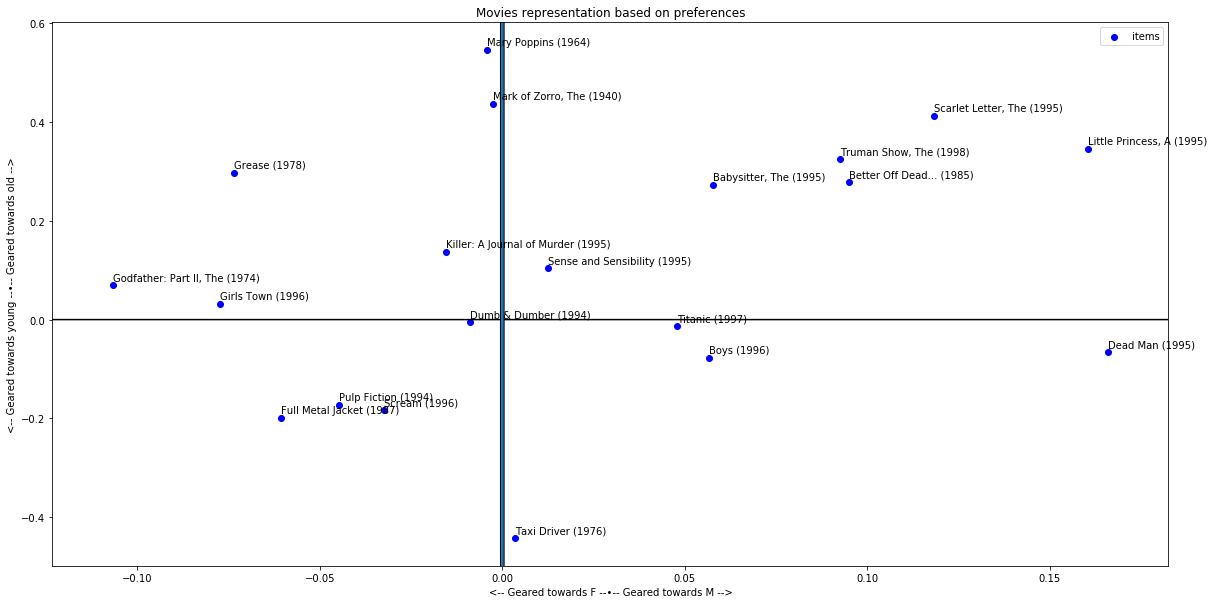

In [129]:
plt.figure(figsize=(20,10))
plt.title('Movies representation based on preferences')
plt.scatter(x_item,y_item, c='b', label='items')

for x,y,i in zip(x_item,y_item,ind_movies):
    label = items['title'].iloc[i]
    plt.annotate(label,(x,y), xytext=(x,y+0.01))

plt.arrow(-1,0,2,0)
plt.arrow(0,-1,0,2)
plt.xlabel('<-- Geared towards F --•-- Geared towards M -->')
plt.ylabel('<-- Geared towards young --•-- Geared towards old -->')
plt.legend()

This graph offers a recommendation of movies based on the users' sexe and age.

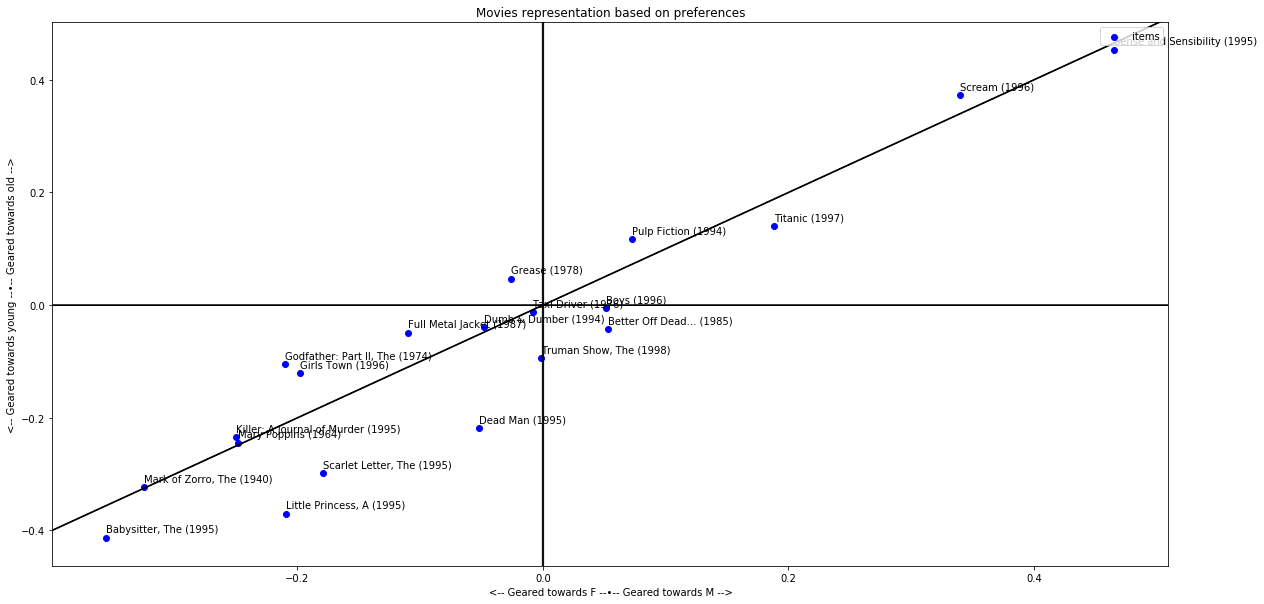

In [130]:
plt.figure(figsize=(20,10))
plt.title('Movies representation based on preferences')
plt.scatter(x_item_1,y_item_1, c='b', label='items')

for x,y,i in zip(x_item_1,y_item_1,ind_movies):
    label = items['title'].iloc[i]
    plt.annotate(label,(x,y), xytext=(x,y+0.01))

plt.arrow(-1,0,2,0)
plt.arrow(0,-1,0,2)
plt.arrow(-1,-1,2,2)
plt.xlabel('<-- Geared towards F --•-- Geared towards M -->')
plt.ylabel('<-- Geared towards young --•-- Geared towards old -->')
plt.legend()

#### 3. Recommender systems to get insights on our society

Finally, we will see that users' taste for movies can provide interesting information on other aspects of our society (supposedly uncorelated).

In [131]:
x_occ = []
y_occ = []
for occ in occ_embedding:
    x_occ.append(np.dot(occ,-M)-np.dot(occ,-F))
    y_occ.append(np.dot(occ,-old)-np.dot(occ,-young))

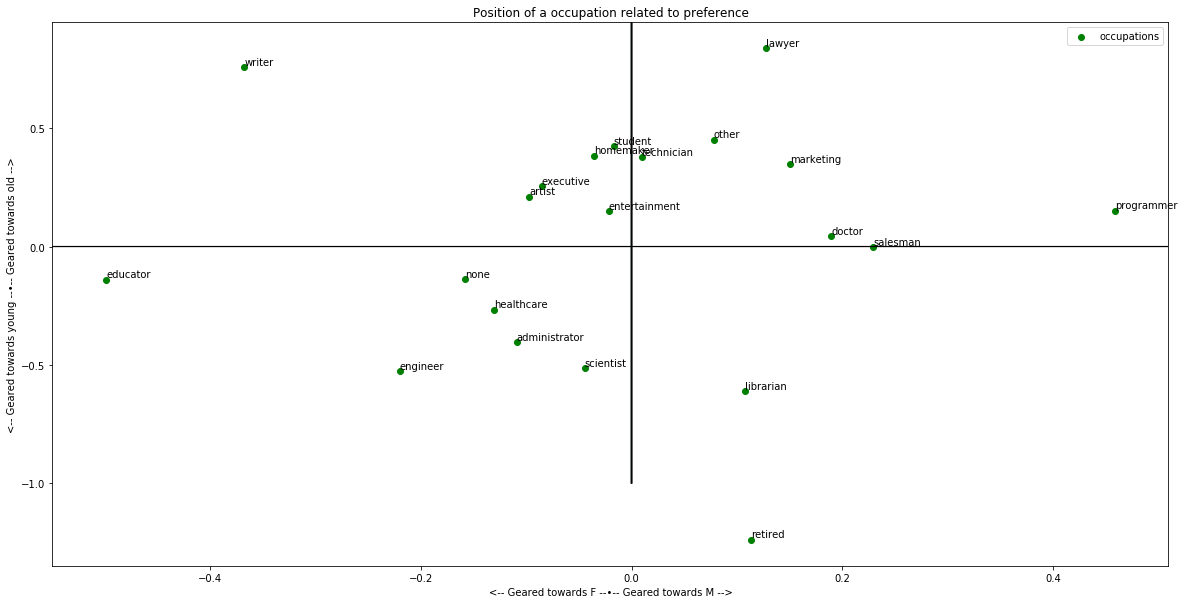

In [132]:
plt.figure(figsize=(20,10))
plt.title('Position of a occupation related to preference')
plt.scatter(x_occ,y_occ, c='g', label='occupations')
i = 0
for x,y in zip(x_occ,y_occ):
    label = occupations[i,0]
    i += 1
    plt.annotate(label,(x,y), xytext=(x,y+0.01))

plt.arrow(-1,0,2,0)
plt.arrow(0,-1,0,2)
plt.xlabel('<-- Geared towards F --•-- Geared towards M -->')
plt.ylabel('<-- Geared towards young --•-- Geared towards old -->')
plt.legend()

### Use PCA to visualize categories in a 2D plane

In [133]:
#from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [134]:
A = np.dot(genre_embedding,genre_embedding.T)
pca = PCA(2)
# fit on data
pca.fit(A)
# access values and vectors
x_occ,y_occ = pca.components_

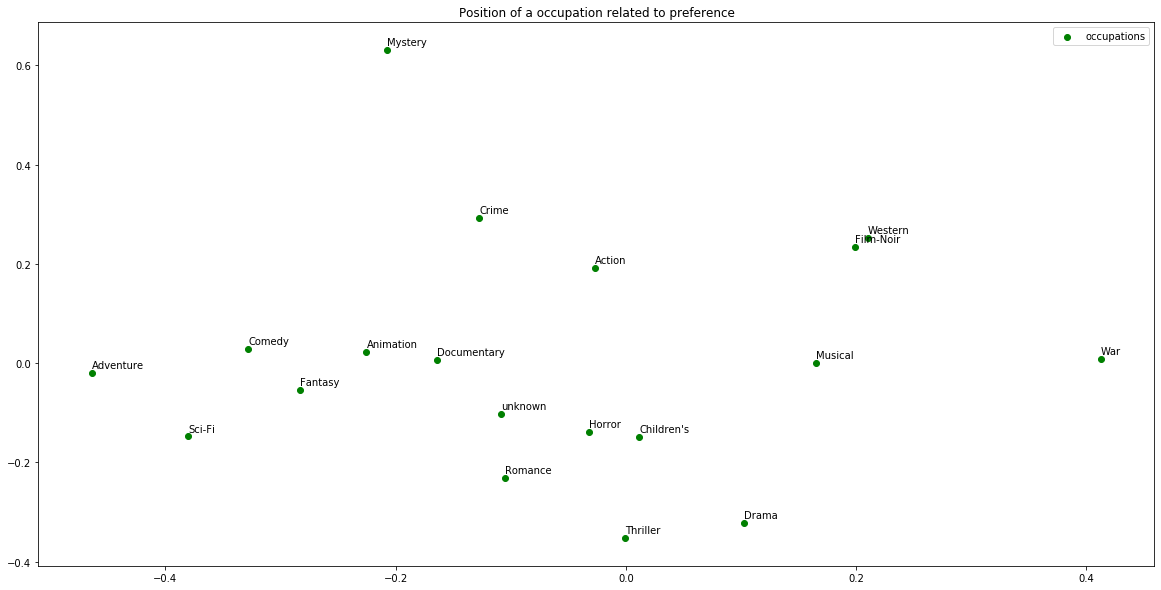

In [140]:
plt.figure(figsize=(20,10))
plt.title('Position of a occupation related to preference')
plt.scatter(x_occ,y_occ, c='g', label='occupations')
i = 0
for x,y in zip(x_occ,y_occ):
    label = df_genre['genres'].iloc[i]
    i += 1
    plt.annotate(label,(x,y), xytext=(x,y+0.01))
plt.legend()

### Conclusion

TO DO:
- graph M en x et F en y
- graph cos sim des occ (use SVD - spicy), use spectral
    -> use louvain to 
- graoh bipartite occ/movies (same use bispectral)